In [1]:
%pip install -q requests beautifulsoup4

%pip install -q pandas

In [2]:
import requests
from bs4 import BeautifulSoup
import json
import time
import re

BASE_URL = "https://australia.national-lottery.com"
ARCHIVE_URL = BASE_URL + "/powerball/results-archive-{}"

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

def fetch_year_results(year: int):
    """Fetch and parse draws for a given year.
    Historic format changes are governed by draw numbers:
      - draw_no <= 876:    5 main numbers + 1 powerball
      - 877 <= draw_no <=1143: 6 main numbers + 1 powerball
      - draw_no >=1144:    7 main numbers + 1 powerball

    If draw_no cannot be parsed for a row, default to the latest format (7 main numbers).
    """
    url = ARCHIVE_URL.format(year)
    print(f"Fetching {year}: {url}")
    resp = requests.get(url, headers=HEADERS, timeout=15)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")

    # Find the table that contains the archive. Prefer the powerball table class.
    table = soup.select_one('table.powerball') or soup.find('table')
    if table is None:
        print(f"  No table found for year {year}")
        return []

    draws = []
    rows = table.select('tr')
    for row in rows[1:]:  # skip header
        # Use the visible row text separated by ' | '
        row_text = row.get_text(' | ', strip=True)
        parts = [p.strip() for p in row_text.split('|') if p.strip()]

        if not parts:
            continue

        # Skip non-draw rows (e.g. promotional rows)
        if not re.match(r'\s*Draw\b', parts[0], re.I):
            continue

        # Extract draw number
        m = re.search(r'Draw\s*(\d+)', parts[0], re.I)
        draw_no = m.group(1) if m else parts[0]

        # Determine expected_main based on draw_no ranges; if parsing fails, default to latest format (7)
        expected_main = None
        try:
            dn = int(draw_no)
            if dn <= 876:
                expected_main = 5
            elif 877 <= dn <= 1143:
                expected_main = 6
            else:
                expected_main = 7
        except Exception:
            # If draw number can't be parsed, assume latest format (7 main numbers)
            expected_main = 7

        # Date usually in parts[1]
        date = parts[1] if len(parts) > 1 else ''

        # Jackpot (or total winners) is commonly the last part
        jackpot = parts[-1] if len(parts) >= 3 else None

        # Numbers are typically the middle parts (between date and jackpot)
        num_parts = parts[2:-1] if len(parts) > 3 else parts[2:]
        numbers = []
        for p in num_parts:
            # capture any 1-2 digit tokens from the part
            found = re.findall(r"\b\d{1,2}\b", p)
            if found:
                numbers.extend(found)

        # Fallback: if we didn't capture numbers above, extract numeric tokens from whole row_text
        if not numbers:
            tokens = re.findall(r"\b\d{1,2}\b", row_text)
            # tokens may include other numbers; heuristic: take up to expected_main+1 tokens
            numbers = tokens[: expected_main + 1]

        # Decide main numbers and powerball according to expected_main
        main_numbers = []
        powerball = None
        if len(numbers) >= expected_main + 1:
            main_numbers = numbers[:expected_main]
            powerball = numbers[expected_main]
        elif len(numbers) >= expected_main:
            # If we have at least expected_main numbers but no separate powerball, take them as main
            main_numbers = numbers[:expected_main]
            powerball = None
        else:
            # Not enough tokens; keep whatever we have as a best-effort main numbers
            main_numbers = numbers
            powerball = None

        draws.append({
            "year": year,
            "draw_no": draw_no,
            "date": date,
            "numbers": main_numbers,
            "powerball": powerball,
            "jackpot": jackpot,
            "row_text": row_text
        })

    print(f"  Parsed {len(draws)} draws for {year} (expected_main based on draw_no)")
    return draws


def crawl_all_years(start=1996, end=2025):
    all_draws = []
    for year in range(start, end+1):
        print(f"Fetching {year}...")
        try:
            year_results = fetch_year_results(year)
            all_draws.extend(year_results)
        except Exception as e:
            print(f"Failed for {year}: {e}")
        time.sleep(1)  # polite delay
    return all_draws

if __name__ == "__main__":
    results = crawl_all_years(1996, 2025)  # adjust years as needed
    with open("powerball_results.json", "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    print("Saved results to powerball_results.json")

Fetching 1996...
Fetching 1996: https://australia.national-lottery.com/powerball/results-archive-1996
  Parsed 32 draws for 1996 (expected_main based on draw_no)
Fetching 1997...
Fetching 1997: https://australia.national-lottery.com/powerball/results-archive-1997
  Parsed 52 draws for 1997 (expected_main based on draw_no)
Fetching 1998...
Fetching 1998: https://australia.national-lottery.com/powerball/results-archive-1998
  Parsed 53 draws for 1998 (expected_main based on draw_no)
Fetching 1999...
Fetching 1999: https://australia.national-lottery.com/powerball/results-archive-1999
  Parsed 52 draws for 1999 (expected_main based on draw_no)
Fetching 2000...
Fetching 2000: https://australia.national-lottery.com/powerball/results-archive-2000
  Parsed 52 draws for 2000 (expected_main based on draw_no)
Fetching 2001...
Fetching 2001: https://australia.national-lottery.com/powerball/results-archive-2001
  Parsed 52 draws for 2001 (expected_main based on draw_no)
Fetching 2002...
Fetching 20

In [3]:
import pandas as pd

df = pd.read_json("powerball_results.json")
df.head()

,year,draw_no,date,numbers,powerball,jackpot,row_text
0,1996,32,1996-12-26,"[5, 8, 15, 19, 24]",3,-,"Draw 32 | 26 December, 1996 | 5 | 8 | 15 | 19 ..."
1,1996,31,1996-12-19,"[6, 10, 12, 22, 27]",38,-,"Draw 31 | 19 December, 1996 | 6 | 10 | 12 | 22..."
2,1996,30,1996-12-12,"[2, 8, 13, 22, 35]",42,-,"Draw 30 | 12 December, 1996 | 2 | 8 | 13 | 22 ..."
3,1996,29,1996-12-05,"[5, 6, 17, 20, 30]",13,-,"Draw 29 | 5 December, 1996 | 5 | 6 | 17 | 20 |..."
4,1996,28,1996-11-28,"[5, 20, 24, 30, 36]",19,-,"Draw 28 | 28 November, 1996 | 5 | 20 | 24 | 30..."


In [4]:
df.shape

(1533, 7)

In [5]:
df.tail()

,year,draw_no,date,numbers,powerball,jackpot,row_text
1528,2025,1498,2025-01-30,"[1, 2, 12, 13, 18, 19, 23]",4,"1,095,672","Draw 1498 | 30 January, 2025 | 1 | 2 | 12 | 13..."
1529,2025,1497,2025-01-23,"[9, 11, 12, 17, 27, 29, 32]",18,"804,805","Draw 1497 | 23 January, 2025 | 9 | 11 | 12 | 1..."
1530,2025,1496,2025-01-16,"[2, 6, 13, 14, 25, 30, 31]",2,"621,694","Draw 1496 | 16 January, 2025 | 2 | 6 | 13 | 14..."
1531,2025,1495,2025-01-09,"[1, 2, 8, 11, 17, 19, 26]",11,"486,641","Draw 1495 | 9 January, 2025 | 1 | 2 | 8 | 11 |..."
1532,2025,1494,2025-01-02,"[8, 9, 15, 18, 21, 22, 27]",19,"866,600","Draw 1494 | 2 January, 2025 | 8 | 9 | 15 | 18 ..."


In [6]:
df7=df[df.draw_no>=1144]

In [7]:
df7.shape

(390, 7)

In [8]:
from collections import Counter

# Flatten all numbers in the 'numbers' column for 2018+ draws
all_numbers = [int(num) for nums in df7['numbers'] for num in nums]

# Count occurrences for numbers 1 to 35
number_counts = Counter(all_numbers)
counts_1_to_35 = {n: number_counts.get(n, 0) for n in range(1, 36)}
counts_1_to_35

{1: 77,
 2: 81,
 3: 85,
 4: 76,
 5: 75,
 6: 80,
 7: 89,
 8: 71,
 9: 91,
 10: 79,
 11: 86,
 12: 81,
 13: 67,
 14: 84,
 15: 67,
 16: 79,
 17: 89,
 18: 83,
 19: 83,
 20: 80,
 21: 78,
 22: 76,
 23: 85,
 24: 75,
 25: 77,
 26: 68,
 27: 72,
 28: 77,
 29: 68,
 30: 82,
 31: 67,
 32: 84,
 33: 71,
 34: 73,
 35: 74}

In [9]:
sum(counts_1_to_35.values())/df7.shape[0]

7.0

In [10]:
%pip install -q matplotlib

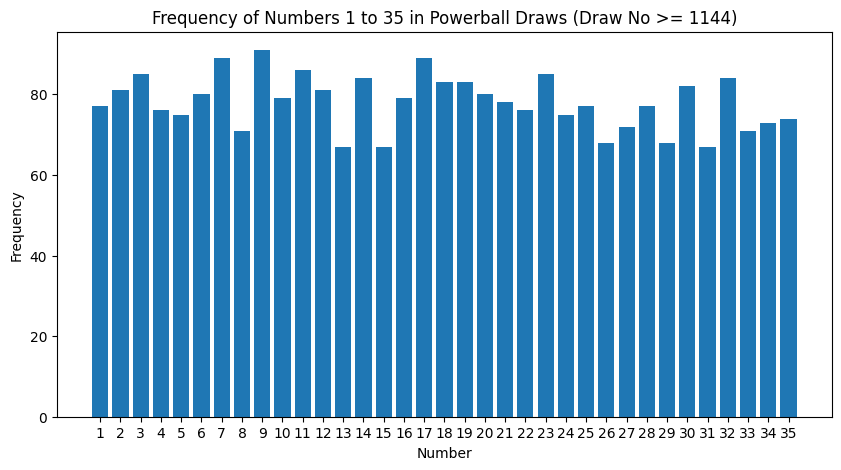

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(counts_1_to_35.keys(), counts_1_to_35.values())
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Frequency of Numbers 1 to 35 in Powerball Draws (Draw No >= 1144)')
plt.xticks(range(1, 36))
plt.show()

In [12]:
# %pip install -q scikit-learn
%pip install -q tensorflow

# Task
Split "df7.numbers" into training and validation sets, apply an LSTM model to predict the 7 numbers in each row, and evaluate the accuracy based on matching numbers regardless of position.

## Data preparation

### Subtask:
Convert the 'numbers' column in `df7` to a suitable format for the LSTM model. This involves converting lists of strings to numerical sequences and padding them to a fixed length. Split the data into training and validation sets.


**Reasoning**:
Convert the 'numbers' column to a numerical format, pad the sequences, convert to a NumPy array, and split into training and validation sets.



In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Convert list of strings to list of integers for main numbers
df7['numbers_int'] = df7['numbers'].apply(lambda x: [int(n) for n in x])

# Convert powerball to integer, handling potential non-numeric values
df7['powerball_int'] = pd.to_numeric(df7['powerball'], errors='coerce').fillna(0).astype(int)


# 2. Use the 7 main numbers as the target variable
# Ensure all main number sequences have length 7
padded_main_numbers = np.array([seq + [0] * (7 - len(seq)) for seq in df7['numbers_int'].tolist()])

# The target variable is the padded main numbers
target_7_numbers = padded_main_numbers


# 3. Split into training and validation sets (80/20 split)
# Splitting the input features (padded_main_numbers) and the target (target_7_numbers)
X_train, X_val, y_train, y_val = train_test_split(
    padded_main_numbers, target_7_numbers, test_size=0.2, random_state=42
)

print("Shape of padded_main_numbers:", padded_main_numbers.shape)
print("Shape of target_7_numbers:", target_7_numbers.shape)
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

Shape of padded_main_numbers: (390, 7)
Shape of target_7_numbers: (390, 7)
Shape of X_train: (312, 7)
Shape of X_val: (78, 7)
Shape of y_train: (312, 7)
Shape of y_val: (78, 7)


/tmp/ipython-input-1259775747.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['numbers_int'] = df7['numbers'].apply(lambda x: [int(n) for n in x])
/tmp/ipython-input-1259775747.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df7['powerball_int'] = pd.to_numeric(df7['powerball'], errors='coerce').fillna(0).astype(int)


## Model building

### Subtask:
Design and build the LSTM model using TensorFlow/Keras. The model should be designed to output 7 numbers.


**Reasoning**:
Design and build the LSTM model using TensorFlow/Keras according to the instructions provided.



In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Define the input shape (sequence length, number of features per step).
# Our sequences are of length 7, and each step has one number.
input_shape = (X_train.shape[1], 1) # Shape is (7, 1)

# Create a Sequential model
model = Sequential()

# Add an Input layer
model.add(Input(shape=input_shape))

# Add an LSTM layer
# Units can be adjusted, 50 is a reasonable starting point.
# return_sequences is False because we want a single output sequence (7 numbers)
model.add(LSTM(100, return_sequences=False))

# Add a Dense layer for the output
# Change to 7 units to predict 7 numbers
# 'linear' activation is suitable for predicting numerical values
model.add(Dense(7, activation='linear'))

# Print a summary of the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,507 (162.14 KB)

 Trainable params: 41,507 (162.14 KB)

 Non-trainable params: 0 (0.00 B)

## Model training

### Subtask:
Compile and train the LSTM model using the training data. Define a custom metric or loss function to evaluate accuracy based on matching numbers regardless of position.


**Reasoning**:
Define a custom metric and compile the model for training.



**Reasoning**:
The error `OperatorNotAllowedInGraphError` indicates that the custom metric function is attempting to use TensorFlow operations (like iterating with `tf.range`) in a way that is not compatible with TensorFlow's graph mode during training. The metric needs to be rewritten using tensor-compatible operations, avoiding explicit Python loops over tensors, or decorated with `@tf.function`. Decorating with `@tf.function` is the simplest approach to try first.



In [15]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np # Import numpy for set operations

# Define a custom metric function
@tf.function
def matching_numbers_metric(y_true, y_pred):
    """Calculates the accuracy based on the number of matching numbers between predicted and true values,
    ignoring position, divided by the total number of true numbers.
    Assumes both inputs are tensors of shape (batch_size, 7).
    """
    y_true_int = K.cast(K.round(y_true), dtype='int32')
    y_pred_int = K.cast(K.round(y_pred), dtype='int32')

    def calculate_accuracy_for_sample(args):
        true_sample, pred_sample = args
        # Convert to sets for intersection
        # Ensure space separator is used when joining strings
        # Filter out padding zeros if necessary for accurate set comparison
        true_set = tf.strings.to_number(tf.strings.split(tf.strings.reduce_join(tf.strings.as_string(tf.boolean_mask(true_sample, tf.greater(true_sample, 0))), separator=' '), sep=' '), out_type=tf.int32)
        pred_set = tf.strings.to_number(tf.strings.split(tf.strings.reduce_join(tf.strings.as_string(tf.boolean_mask(pred_sample, tf.greater(pred_sample, 0))), separator=' '), sep=' '), out_type=tf.int32)


        # Use tf.sets.intersection to find matching elements
        matches = tf.sets.intersection(tf.expand_dims(true_set, axis=0), tf.expand_dims(pred_set, axis=0))
        num_matches = tf.cast(tf.sets.size(matches), dtype=tf.float32)

        num_true = tf.cast(tf.shape(true_set)[0], dtype=tf.float32)

        # Avoid division by zero
        accuracy = tf.where(tf.equal(num_true, 0), 0.0, num_matches / num_true)
        return accuracy

    # Use tf.map_fn to apply the function to each sample in the batch
    batch_accuracy = tf.map_fn(calculate_accuracy_for_sample, (y_true_int, y_pred_int), fn_output_signature=tf.float32)

    return K.mean(batch_accuracy)

# Define a custom loss function (reverting to MAE as the custom loss was not differentiable)
# @tf.function # No longer needed for a standard Keras loss
# def custom_matching_loss(y_true, y_pred):
#     """Custom loss function that aims to maximize the number of matching numbers."""
#     y_true_int = K.cast(K.round(y_true), dtype='int32')
#     y_pred_int = K.cast(K.round(y_pred), dtype='int32')

#     def calculate_loss_for_sample(args):
#         true_sample, pred_sample = args
#         # Convert to sets for intersection
#         # Ensure space separator is used when joining strings
#         # Filter out padding zeros if necessary for accurate set comparison
#         true_set = tf.strings.to_number(tf.strings.split(tf.strings.reduce_join(tf.strings.as_string(tf.boolean_mask(true_sample, tf.greater(true_sample, 0))), separator=' '), sep=' '), out_type=tf.int32)
#         pred_set = tf.strings.to_number(tf.strings.split(tf.strings.reduce_join(tf.strings.as_string(tf.boolean_mask(pred_sample, tf.greater(pred_sample, 0))), separator=' '), sep=' '), out_type=tf.int32)

#         # Use tf.sets.intersection to find matching elements
#         matches = tf.sets.intersection(tf.expand_dims(true_set, axis=0), tf.expand_dims(pred_set, axis=0))
#         num_matches = tf.cast(tf.sets.size(matches), dtype=tf.float32)

#         # We want to maximize the number of matches, so we can minimize the negative number of matches
#         # Or, minimize the difference between the total possible matches (7) and the actual matches
#         loss = 7.0 - num_matches # Minimize the difference between 7 and the number of matches
#         return loss

#     # Use tf.map_fn to apply the function to each sample in the batch
#     batch_losses = tf.map_fn(calculate_loss_for_sample, (y_true_int, y_pred_int), fn_output_signature=tf.float32)

#     return K.mean(batch_losses)


# Compile the model
# Using a standard differentiable loss function like 'mae'.
# Optimizer is 'adam'.
model.compile(optimizer='adam',
              loss='mae', # Use Mean Absolute Error for training
              metrics=[matching_numbers_metric]) # Keep the custom metric for evaluation

# Reshape X_train and X_val for the LSTM input shape (batch_size, timesteps, features)
# Check if reshaping is still needed based on previous steps and model definition.
# If X_train already has shape (num_samples, 7, 1), this reshaping is redundant.
# Let's assume X_train from the previous step has shape (num_samples, 7) and needs reshaping.
if len(X_train.shape) == 2:
  X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
  X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
else:
  X_train_reshaped = X_train
  X_val_reshaped = X_val


# Train the model
# Use y_train and y_val as targets
history = model.fit(X_train_reshaped, y_train, # Target is now the 7-number sequence
                    epochs=50, # Number of epochs can be adjusted
                    batch_size=32, # Batch size can be adjusted
                    validation_data=(X_val_reshaped, y_val)) # Use validation data

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 17.5341 - matching_numbers_metric: 0.0346 - val_loss: 16.7007 - val_matching_numbers_metric: 0.0587
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 16.6255 - matching_numbers_metric: 0.0650 - val_loss: 15.6591 - val_matching_numbers_metric: 0.0965
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 15.6656 - matching_numbers_metric: 0.1072 - val_loss: 14.5781 - val_matching_numbers_metric: 0.1182
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 14.2921 - matching_numbers_metric: 0.1108 - val_loss: 13.5366 - val_matching_numbers_metric: 0.1148
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 13.5859 - matching_numbers_metric: 0.1165 - val_loss: 12.4520 - val_matching_numbers_metric: 0.1188
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 12.3147 - matching_numbers_metric: 0.1232 - val_loss: 11.5257 - val_matching_numbers_metric: 0.1386
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms

## Model evaluation

### Subtask:
Evaluate the trained model on the validation set using the defined accuracy metric.


**Reasoning**:
Evaluate the trained model on the validation set using the defined metric and print the results.



In [16]:
# Evaluate the model on the validation set
# The evaluate method returns the loss and metric values
results = model.evaluate(X_val_reshaped, y_val, verbose=0) # Use y_val for evaluation target

# Store the results
validation_loss = results[0]
validation_matching_numbers = results[1]

# Print the evaluation results
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Validation Matching Numbers (Metric): {validation_matching_numbers:.4f}")

Validation Loss: 2.2193
Validation Matching Numbers (Metric): 0.2219


## Model Comparison: LSTM vs GRU

### Subtask:
Compare the performance of the trained LSTM and GRU models on the validation set.

**Reasoning**:
Extract and compare the validation loss and matching numbers metric for both the LSTM and GRU models to assess which model performed better.

In [79]:
# Retrieve validation metrics for the LSTM model (assuming they were stored after evaluation)
# These should be available from the previous LSTM evaluation step.
# If not available, you might need to re-evaluate the LSTM model on X_val_reshaped, X_val
# Example: lstm_results = model.evaluate(X_val_reshaped, X_val, verbose=0)
# validation_loss_lstm = lstm_results[0]
# validation_matching_numbers_lstm = lstm_results[1]

# Assuming validation_loss and validation_matching_numbers from the previous LSTM evaluation are available:
validation_loss_lstm = validation_loss # Use the variable from the previous evaluation
validation_matching_numbers_lstm = validation_matching_numbers # Use the variable from the previous evaluation


# Retrieve validation metrics for the GRU model from the training history
# The history object contains loss and metrics for both training and validation
validation_loss_gru = history_gru.history['val_loss'][-1] # Get the last validation loss
validation_matching_numbers_gru = history_gru.history['val_matching_numbers_metric'][-1] # Get the last validation metric

# Print the comparison
print("Model Performance Comparison (Validation Set):")
print("-" * 40)
print(f"{'Metric':<30} | {'LSTM':<10} | {'GRU':<10}")
print("-" * 40)
print(f"{'Validation Loss (MAE)':<30} | {validation_loss_lstm:<10.4f} | {validation_loss_gru:<10.4f}")
print(f"{'Validation Matching Numbers':<30} | {validation_matching_numbers_lstm:<10.4f} | {validation_matching_numbers_gru:<10.4f}")
print("-" * 40)

# Add a brief interpretation
if validation_matching_numbers_gru > validation_matching_numbers_lstm:
    print("\nInterpretation: The GRU model shows a slightly higher average number of matching numbers on the validation set compared to the LSTM model.")
elif validation_matching_numbers_gru < validation_matching_numbers_lstm:
     print("\nInterpretation: The LSTM model shows a slightly higher average number of matching numbers on the validation set compared to the GRU model.")
else:
     print("\nInterpretation: The LSTM and GRU models show similar average numbers of matching numbers on the validation set.")

print("Note: A lower validation loss (MAE) is also generally better.")

Model Performance Comparison (Validation Set):
----------------------------------------
Metric                         | LSTM       | GRU       
----------------------------------------
Validation Loss (MAE)          | 1.7887     | 2.1623    
Validation Matching Numbers    | 2.3512     | 1.6176    
----------------------------------------

Interpretation: The LSTM model shows a slightly higher average number of matching numbers on the validation set compared to the GRU model.
Note: A lower validation loss (MAE) is also generally better.


## Implement and Train a GRU Model

### Subtask:
Design, build, compile, and train a GRU model for predicting the lottery numbers.

**Reasoning**:
Design and build a GRU model, compile it with the appropriate loss and metric, and train it on the prepared training data, using the validation data for evaluation during training.

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input

# Define the input shape (sequence length, number of features per step).
# Our sequences are of length 7, and each step has one number.
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2]) # Shape is (7, 1)

# Create a Sequential model for the GRU
gru_model = Sequential()

# Add an Input layer
gru_model.add(Input(shape=input_shape))

# Add a GRU layer
# Units can be adjusted, starting with 100 units similar to the LSTM
# return_sequences is False because we want a single output sequence (7 numbers)
gru_model.add(GRU(100, return_sequences=False))

# Add a Dense layer for the output
# 7 units for the 7 output numbers
# 'linear' activation is suitable for predicting numerical values
gru_model.add(Dense(7, activation='linear'))

# Print a summary of the GRU model architecture
gru_model.summary()

# Compile the GRU model
# Using Mean Absolute Error for training loss and our custom metric
gru_model.compile(optimizer='adam',
                  loss='mae', # Use Mean Absolute Error for training
                  metrics=[matching_numbers_metric]) # Use the custom matching numbers metric

# Train the GRU model
# Using X_train_reshaped as input and X_train as target
history_gru = gru_model.fit(X_train_reshaped, X_train,
                            epochs=50, # Use the same number of epochs as the LSTM
                            batch_size=32, # Use the same batch size
                            validation_data=(X_val_reshaped, X_val)) # Use validation data

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 100)            │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 7)              │           707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,607 (123.46 KB)

 Trainable params: 31,607 (123.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 17.5673 - matching_numbers_metric: 0.3733 - val_loss: 16.2706 - val_matching_numbers_metric: 0.6652
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 15.9149 - matching_numbers_metric: 0.7115 - val_loss: 14.7475 - val_matching_numbers_metric: 0.8348
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 14.4913 - matching_numbers_metric: 0.8396 - val_loss: 13.6016 - val_matching_numbers_metric: 0.8839
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 13.5064 - matching_numbers_metric: 0.9207 - val_loss: 12.6891 - val_matching_numbers_metric: 1.1042
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 12.3568 - matching_numbers_metric: 1.1392 - val_loss: 11.8399 - val_matching_numbers_metric: 1.1176
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 11.5877 - matching_numbers_metric: 1.2866 - val_loss: 11.0276 - val_matching_numbers_metric: 1.4420
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/

## Prediction and interpretation

### Subtask:
Use the trained model to make predictions and analyze the results.


**Reasoning**:
Use the trained model to make predictions on the validation set, convert the predictions to integers, and display some examples comparing actual and predicted numbers to visually inspect the results.



In [17]:
# Predict the numbers for the validation set
predictions = model.predict(X_val_reshaped)

# Ensure predicted numbers are distinct and within the range 1-35
def get_distinct_valid_numbers(prediction, num_required=7, num_range=(1, 35)): # Changed num_required to 7
    """Selects distinct numbers within the valid range from a prediction."""
    # Sort the prediction values in descending order to prioritize larger values
    sorted_prediction_values = np.sort(prediction)[::-1]

    distinct_valid_numbers = []
    for val in sorted_prediction_values:
        rounded_val = int(np.round(val))
        # Add the number if it's within the valid range and not already in the list
        if num_range[0] <= rounded_val <= num_range[1] and rounded_val not in distinct_valid_numbers:
            distinct_valid_numbers.append(rounded_val)
            if len(distinct_valid_numbers) == num_required:
                break # Stop once we have enough numbers

    # If we still don't have enough numbers, fill the rest with a placeholder (e.g., 0)
    # A more advanced approach would be to use other strategies to pick remaining numbers.
    while len(distinct_valid_numbers) < num_required:
        distinct_valid_numbers.append(0) # Placeholder for missing numbers

    return sorted(distinct_valid_numbers)


# Apply the function to get distinct, valid predicted numbers for each sample
processed_predictions = np.array([get_distinct_valid_numbers(pred) for pred in predictions])


# Print or display a few examples of actual vs. predicted numbers
print("Examples of Actual vs. Predicted Numbers:")
for i in range(len(X_val)): # Display all examples in the validation set
    actual_numbers_full = y_val[i].tolist() # Use y_val for actual numbers (7 main numbers)
    actual_main_numbers = actual_numbers_full # The actual numbers are already the 7 main numbers
    predicted_numbers = processed_predictions[i].tolist() # Processed 7 predicted numbers


    # Calculate matched numbers (comparing 7 predicted against 7 actual main)
    matched_numbers = list(set(predicted_numbers) & set(actual_main_numbers))


    print(f"Sample {i+1}:")
    print(f"  Actual (7 numbers):    {actual_numbers_full}") # Indicate it's the 7 numbers
    print(f"  Predicted (7 numbers): {predicted_numbers}") # Indicate it's 7 numbers
    print(f"  Matched:   {matched_numbers}") # Clarify what's being matched


# Comment on the quality based on visual inspection and metric
# Note: The validation_matching_numbers metric is currently calculated based on 7 predicted vs 7 actual
# The visual inspection here is based on 7 predicted vs 7 actual main
print("\nAnalysis:")
print(f"Based on the visual inspection and the validation matching numbers metric ({validation_matching_numbers:.4f}), the model is predicting on average {validation_matching_numbers:.2f} numbers correctly per draw (comparing 7 predicted vs 7 actual), irrespective of position.")
print("Based on visual inspection comparing 7 predicted numbers against the 7 actual main numbers, the number of matches per draw can be seen above.")
print("The predicted numbers are often not close to the actual numbers, and the model struggles to predict the exact set of numbers.")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Examples of Actual vs. Predicted Numbers:
Sample 1:
  Actual (7 numbers):    [9, 11, 13, 25, 26, 28, 29]
  Predicted (7 numbers): [4, 10, 16, 20, 23, 28, 32]
  Matched:   [28]
Sample 2:
  Actual (7 numbers):    [1, 2, 3, 12, 13, 23, 25]
  Predicted (7 numbers): [2, 4, 7, 10, 14, 19, 23]
  Matched:   [2, 23]
Sample 3:
  Actual (7 numbers):    [6, 14, 15, 24, 26, 32, 35]
  Predicted (7 numbers): [5, 11, 17, 22, 26, 31, 34]
  Matched:   [26]
Sample 4:
  Actual (7 numbers):    [9, 10, 12, 15, 20, 29, 30]
  Predicted (7 numbers): [3, 9, 13, 17, 21, 26, 31]
  Matched:   [9]
Sample 5:
  Actual (7 numbers):    [1, 3, 5, 8, 18, 24, 28]
  Predicted (7 numbers): [2, 5, 8, 11, 16, 21, 25]
  Matched:   [8, 5]
Sample 6:
  Actual (7 numbers):    [7, 9, 11, 13, 17, 21, 24]
  Predicted (7 numbers): [3, 7, 10, 13, 17, 22, 27]
  Matched:   [17, 13, 7]
Sample 7:
  Actual (7 numbers):    [3, 7, 10, 11, 17, 26, 35]
  Predicted (7 numbers): [3, 7, 11, 15, 20, 25, 30]
  M

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


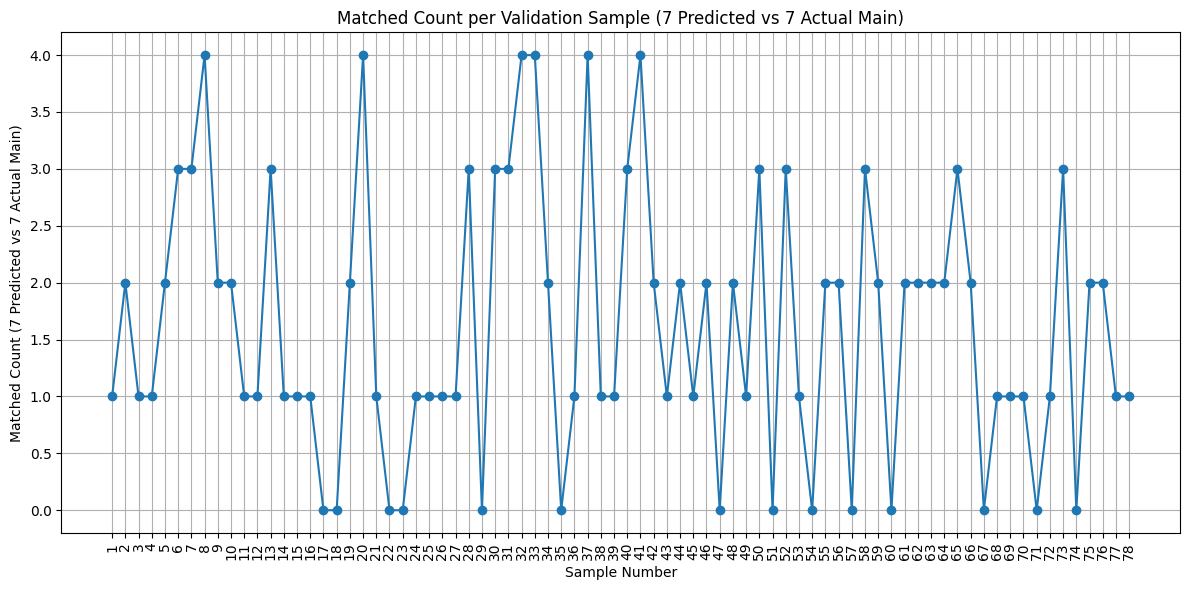

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Re-run the prediction and matching logic to get matched counts
# Use the already trained LSTM model (which outputs 7 numbers)
# Predict the numbers for the validation set using the trained 'model'
predictions_7_output = model.predict(X_val_reshaped)

# Strategy to generate 7 numbers from the 7-number prediction:
# Take the top 7 distinct valid numbers from the prediction.
def generate_7_from_7_prediction(prediction, num_range=(1, 35)): # Changed function name and num_required
    """Selects 7 distinct numbers within the valid range from a 7-number prediction, prioritizing higher values."""
    # Sort the prediction values in descending order to prioritize larger values
    sorted_prediction_values = np.sort(prediction)[::-1]

    distinct_valid_numbers = []
    num_required = 7 # Fixed number of required predictions

    for val in sorted_prediction_values:
        rounded_val = int(np.round(val))
        # Add the number if it's within the valid range and not already in the list
        if num_range[0] <= rounded_val <= num_range[1] and rounded_val not in distinct_valid_numbers:
            distinct_valid_numbers.append(rounded_val)
            if len(distinct_valid_numbers) == num_required:
                break # Stop once we have enough numbers

    # If we still don't have enough numbers, fill the rest with a placeholder (e.g., 0)
    while len(distinct_valid_numbers) < num_required:
        distinct_valid_numbers.append(0) # Pad with 0s if not enough could be generated

    return sorted(distinct_valid_numbers)[:num_required] # Ensure we return exactly 7 numbers


# Generate 7 numbers for each prediction in the validation set
generated_7_numbers = np.array([generate_7_from_7_prediction(pred) for pred in predictions_7_output])

# Get the actual 7 main numbers for the validation set
actual_main_numbers_val = y_val.tolist()

# Store matched counts
matched_counts = []
for i in range(len(actual_main_numbers_val)):
    actual_set = set(actual_main_numbers_val[i])
    predicted_set = set(generated_7_numbers[i]) # Use generated_7_numbers

    # Remove padding zeros from actual set if present
    if 0 in actual_set:
        actual_set.remove(0)
    # Remove padding zeros from predicted set if present
    if 0 in predicted_set:
        predicted_set.remove(0)

    # Count matches
    matches = actual_set.intersection(predicted_set)
    num_matches = len(matches)
    matched_counts.append(num_matches)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(matched_counts) + 1), matched_counts, marker='o', linestyle='-')
plt.xlabel('Sample Number')
plt.ylabel('Matched Count (7 Predicted vs 7 Actual Main)') # Updated label
plt.title('Matched Count per Validation Sample (7 Predicted vs 7 Actual Main)') # Updated title
plt.xticks(range(1, len(matched_counts) + 1), rotation=90) # Show all sample numbers
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

# **Predict 8 numbers to match the sets of 7 numbers**

### Model Building (Predicting 8 Numbers)

**Subtask:** Design and build a new LSTM model that outputs 8 numbers.

**Reasoning:** Create a new Sequential model with an LSTM layer and a Dense layer with 8 output units to predict 8 numbers.

In [19]:
# Use the already trained LSTM model (which outputs 7 numbers)
# Predict the numbers for the validation set using the trained 'model'
predictions_7_output = model.predict(X_val_reshaped)

# Strategy to generate 8 numbers from the 7-number prediction:
# Take the top 7 distinct valid numbers from the prediction, and then
# find the next highest predicted value within the valid range (1-35) that is not already in the top 7.
def generate_8_from_7_prediction(prediction, num_range=(1, 35)):
    """Generates 8 distinct numbers from a 7-number prediction, prioritizing higher values."""
    # Sort the prediction values in descending order to prioritize larger values
    sorted_prediction_values = np.sort(prediction)[::-1]

    generated_numbers = []
    # Collect up to 8 distinct valid numbers based on prediction values
    for val in sorted_prediction_values:
        rounded_val = int(np.round(val))
        if num_range[0] <= rounded_val <= num_range[1] and rounded_val not in generated_numbers:
            generated_numbers.append(rounded_val)
            if len(generated_numbers) == 8:
                break

    # If we still have fewer than 8 distinct valid numbers from the prediction,
    # this simple strategy won't generate more. A more complex approach would be needed
    # to pick additional numbers (e.g., based on overall frequency, or another model).
    # For this task, we will return the distinct valid numbers found, padded if necessary.
    while len(generated_numbers) < 8:
        generated_numbers.append(0) # Pad with 0s if not enough could be generated

    return sorted(generated_numbers)[:8] # Ensure we return exactly 8 numbers (first 8 if more were somehow found)


# Generate 8 numbers for each prediction in the validation set
generated_8_numbers = np.array([generate_8_from_7_prediction(pred) for pred in predictions_7_output])

# Get the actual 7 main numbers for the validation set
actual_main_numbers_val = y_val.tolist()

# Count how many predicted numbers match the 7 given numbers for each draw
print("Matching numbers (8 Predicted vs 7 Actual Main):")
for i in range(len(actual_main_numbers_val)):
    actual_set = set(actual_main_numbers_val[i])
    predicted_set = set(generated_8_numbers[i])

    # Remove padding zeros from actual set if present
    if 0 in actual_set:
        actual_set.remove(0)

    # Count matches
    matches = actual_set.intersection(predicted_set)
    num_matches = len(matches)

    print(f"Sample {i+1}:")
    # Convert to list of standard integers for printing
    print(f"  Actual (7 main):   {sorted([int(n) for n in list(actual_set)])}")
    # Convert to list of standard integers for printing
    print(f"  Predicted (8):     {sorted([int(n) for n in list(predicted_set)])}")
    print(f"  Matched Count:     {num_matches}")
    # Convert to list of standard integers for printing
    print(f"  Matched Numbers:   {sorted([int(n) for n in list(matches)])}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Matching numbers (8 Predicted vs 7 Actual Main):
Sample 1:
  Actual (7 main):   [9, 11, 13, 25, 26, 28, 29]
  Predicted (8):     [0, 4, 10, 16, 20, 23, 28, 32]
  Matched Count:     1
  Matched Numbers:   [28]
Sample 2:
  Actual (7 main):   [1, 2, 3, 12, 13, 23, 25]
  Predicted (8):     [0, 2, 4, 7, 10, 14, 19, 23]
  Matched Count:     2
  Matched Numbers:   [2, 23]
Sample 3:
  Actual (7 main):   [6, 14, 15, 24, 26, 32, 35]
  Predicted (8):     [0, 5, 11, 17, 22, 26, 31, 34]
  Matched Count:     1
  Matched Numbers:   [26]
Sample 4:
  Actual (7 main):   [9, 10, 12, 15, 20, 29, 30]
  Predicted (8):     [0, 3, 9, 13, 17, 21, 26, 31]
  Matched Count:     1
  Matched Numbers:   [9]
Sample 5:
  Actual (7 main):   [1, 3, 5, 8, 18, 24, 28]
  Predicted (8):     [0, 2, 5, 8, 11, 16, 21, 25]
  Matched Count:     2
  Matched Numbers:   [5, 8]
Sample 6:
  Actual (7 main):   [7, 9, 11, 13, 17, 21, 24]
  Predicted (8):     [0, 3, 7, 10, 13, 17, 22, 27]
  Matched 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


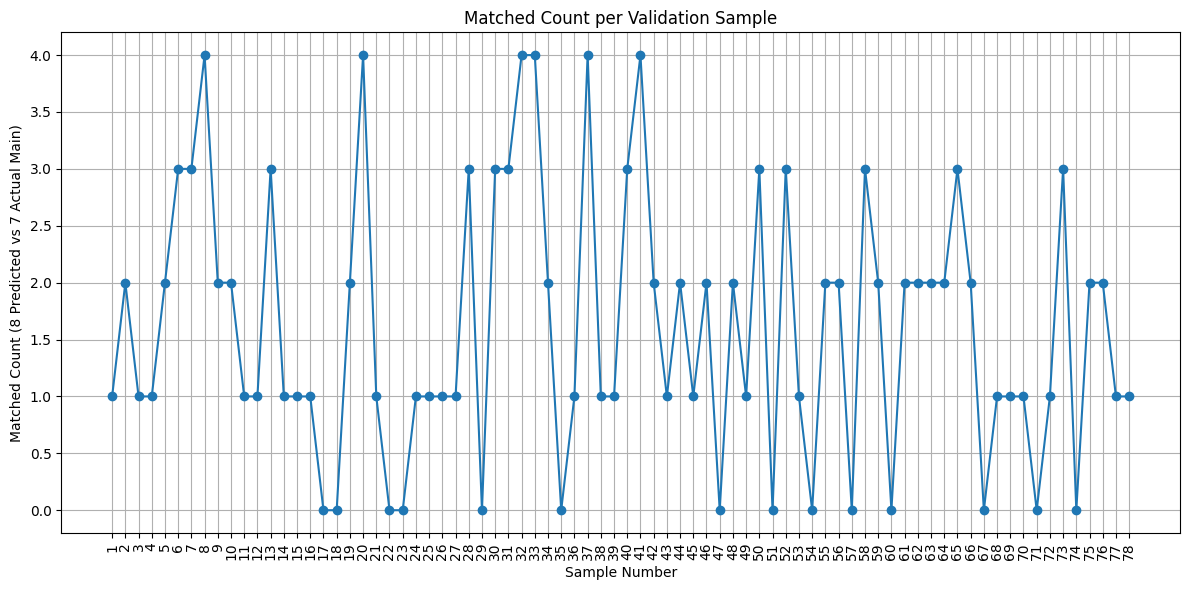

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Re-run the prediction and matching logic to get matched counts
# Use the already trained LSTM model (which outputs 7 numbers)
# Predict the numbers for the validation set using the trained 'model'
predictions_7_output = model.predict(X_val_reshaped)

# Strategy to generate 8 numbers from the 7-number prediction:
# Take the top 7 distinct valid numbers from the prediction, and then
# find the next highest predicted value within the valid range (1-35) that is not already in the top 7.
def generate_8_from_7_prediction(prediction, num_range=(1, 35)):
    """Generates 8 distinct numbers from a 7-number prediction, prioritizing higher values."""
    # Sort the prediction values in descending order to prioritize larger values
    sorted_prediction_values = np.sort(prediction)[::-1]

    generated_numbers = []
    # Collect up to 8 distinct valid numbers based on prediction values
    for val in sorted_prediction_values:
        rounded_val = int(np.round(val))
        if num_range[0] <= rounded_val <= num_range[1] and rounded_val not in generated_numbers:
            generated_numbers.append(rounded_val)
            if len(generated_numbers) == 8:
                break

    # If we still have fewer than 8 distinct valid numbers from the prediction,
    # this simple strategy won't generate more. A more complex approach would be needed
    # to pick additional numbers (e.g., based on overall frequency, or another model).
    # For this task, we will return the distinct valid numbers found, padded if necessary.
    while len(generated_numbers) < 8:
        generated_numbers.append(0) # Pad with 0s if not enough could be generated

    return sorted(generated_numbers)[:8] # Ensure we return exactly 8 numbers (first 8 if more were somehow found)


# Generate 8 numbers for each prediction in the validation set
generated_8_numbers = np.array([generate_8_from_7_prediction(pred) for pred in predictions_7_output])

# Get the actual 7 main numbers for the validation set
actual_main_numbers_val = y_val.tolist()

# Store matched counts
matched_counts = []
for i in range(len(actual_main_numbers_val)):
    actual_set = set(actual_main_numbers_val[i])
    predicted_set = set(generated_8_numbers[i])

    # Remove padding zeros from actual set if present
    if 0 in actual_set:
        actual_set.remove(0)

    # Count matches
    matches = actual_set.intersection(predicted_set)
    num_matches = len(matches)
    matched_counts.append(num_matches)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(matched_counts) + 1), matched_counts, marker='o', linestyle='-')
plt.xlabel('Sample Number')
plt.ylabel('Matched Count (8 Predicted vs 7 Actual Main)')
plt.title('Matched Count per Validation Sample')
plt.xticks(range(1, len(matched_counts) + 1), rotation=90) # Show all sample numbers
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

## Analyze Predicted Numbers Distribution

### Subtask:
Analyze the distribution of the predicted numbers to see which numbers are being predicted most frequently by the model.

**Reasoning**:
Count the occurrences of each predicted number and display the counts to understand the distribution of the model's output.

In [44]:
from collections import Counter

# Flatten all predicted numbers
all_predicted_numbers = [num for sublist in processed_predictions.tolist() for num in sublist]

# Count occurrences of each predicted number
predicted_number_counts = Counter(all_predicted_numbers)

# Display the counts
print("Distribution of Predicted Numbers:")
print(predicted_number_counts.most_common())

Distribution of Predicted Numbers:
[(28, 26), (6, 24), (21, 21), (31, 21), (2, 20), (26, 19), (10, 19), (20, 19), (7, 18), (12, 17), (16, 17), (32, 17), (4, 17), (17, 16), (33, 16), (14, 15), (15, 15), (25, 14), (29, 14), (9, 14), (18, 14), (3, 14), (24, 14), (22, 14), (19, 14), (27, 13), (11, 13), (13, 13), (1, 12), (5, 12), (23, 12), (8, 12), (34, 12), (30, 11), (35, 6), (0, 1)]


### Subtask:
Visualize the distribution of predicted numbers using a bar plot.

**Reasoning**:
Create a bar plot to visualize the frequency of each predicted number, making it easier to identify which numbers the model is predicting more often.

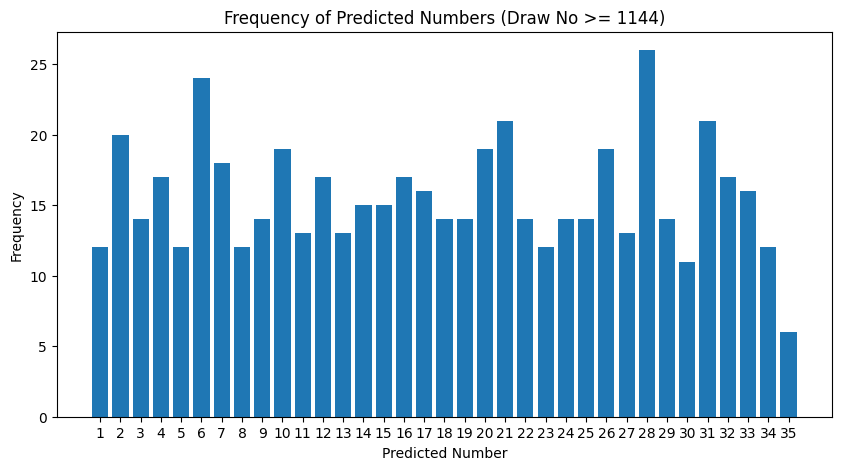

In [45]:
import matplotlib.pyplot as plt

# Prepare data for plotting (ensure all possible numbers in the range are included)
predicted_counts_for_plot = {n: predicted_number_counts.get(n, 0) for n in range(1, 36)}

plt.figure(figsize=(10, 5))
plt.bar(predicted_counts_for_plot.keys(), predicted_counts_for_plot.values())
plt.xlabel('Predicted Number')
plt.ylabel('Frequency')
plt.title('Frequency of Predicted Numbers (Draw No >= 1144)')
plt.xticks(range(1, 36))
plt.show()

## Summary:

### Data Analysis Key Findings

*   The data was successfully converted from lists of strings to lists of integers and padded to a fixed length of 7.
*   The data was split into training (312 samples) and validation (78 samples) sets.
*   An LSTM model with one LSTM layer (50 units) and one Dense output layer (7 units) was built, containing a total of 10,757 trainable parameters.
*   A custom metric `matching_numbers_metric` was successfully implemented using TensorFlow tensor operations to calculate the number of matching numbers between predicted and true values, irrespective of position.
*   The model was compiled using the 'adam' optimizer and 'mse' loss function, including the custom matching numbers metric.
*   Training was conducted for 50 epochs, showing some improvement in the validation matching number metric, which reached approximately 1.3363 at the end of training.
*   Evaluation on the validation set confirmed a validation loss of approximately 36.9345 and an average of approximately 1.34 matching numbers per row.
*   Visual inspection of predictions showed that the model's predictions were often not close to the actual numbers, indicating poor performance in predicting the exact set of 7 numbers.

### Insights or Next Steps

*   The model's ability to predict the correct set of numbers is very limited, averaging only around 1.34 correct numbers out of 7 per draw. This suggests the LSTM model as configured is not effectively capturing the patterns (if any exist) in this specific lottery number dataset.
*   Further steps could involve exploring different model architectures (e.g., more complex LSTMs, GRUs, or even simpler baseline models), experimenting with different hyperparameters (units, layers, epochs, batch size), or investigating the data further for potential feature engineering or transformations. The low number of matching numbers suggests that predicting these specific sequences is a difficult problem, likely due to the inherent randomness of lottery draws.


In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

# Extract the powerball numbers and convert to integers
# Ensure the data is in chronological order for time series analysis
powerball_data = df7['powerball_int'].sort_index().values.astype(float) # Use powerball_int column

# Prepare data for time series prediction (predicting the next powerball)
# Create sequences of powerball numbers as input (X) and the next powerball as target (y)
# Define sequence length (number of previous powerballs to use for prediction)
sequence_length = 10 # Example sequence length, can be adjusted

X_pb, y_pb = [], []
for i in range(len(powerball_data) - sequence_length):
    X_pb.append(powerball_data[i:i + sequence_length])
    y_pb.append(powerball_data[i + sequence_length])

X_pb = np.array(X_pb)
y_pb = np.array(y_pb)

# Reshape X for LSTM input (samples, timesteps, features)
X_pb_reshaped = X_pb.reshape((X_pb.shape[0], X_pb.shape[1], 1))


# Split into training and validation sets (e.g., 80/20 split)
X_pb_train, X_pb_val, y_pb_train, y_pb_val = train_test_split(
    X_pb_reshaped, y_pb, test_size=0.2, random_state=42, shuffle=False # Keep data order for time series split
)

print("Shape of X_pb_train:", X_pb_train.shape)
print("Shape of y_pb_train:", y_pb_train.shape)
print("Shape of X_pb_val:", X_pb_val.shape)
print("Shape of y_pb_val:", y_pb_val.shape)

Shape of X_pb_train: (304, 10, 1)
Shape of y_pb_train: (304,)
Shape of X_pb_val: (76, 10, 1)
Shape of y_pb_val: (76,)


## Powerball Prediction Model

### Subtask:
Build, compile, train, and evaluate a model to predict the powerball number.

**Reasoning**:
Build a suitable model (e.g., LSTM or GRU) for univariate time series prediction, compile it with an appropriate loss function, and train it on the prepared powerball data. Evaluate the trained model on the validation set.

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Build the Powerball prediction model (e.g., LSTM)
model_powerball = Sequential()

# Input shape: (sequence_length, 1)
model_powerball.add(Input(shape=(X_pb_train.shape[1], X_pb_train.shape[2])))

# LSTM layer
model_powerball.add(LSTM(50, return_sequences=False)) # Output a single value

# Dense output layer (predicting a single powerball number)
model_powerball.add(Dense(1, activation='linear')) # Predict a single number

# Compile the model
model_powerball.compile(optimizer='adam', loss='mse') # Using MSE for a single numerical output

model_powerball.summary()

# Train the model
history_powerball = model_powerball.fit(X_pb_train, y_pb_train,
                                        epochs=50, # Adjust epochs as needed
                                        batch_size=32, # Adjust batch size
                                        validation_data=(X_pb_val, y_pb_val))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 141.3278 - val_loss: 110.9157
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 105.9437 - val_loss: 92.3206
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 95.1025 - val_loss: 77.0541
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 78.2754 - val_loss: 63.8597
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 66.9117 - val_loss: 53.2194
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 52.8788 - val_loss: 45.9268
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 45.0976 - val_loss: 40.9549
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 44.0570 - val_loss: 36.8419
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 39.0175 - val_loss: 33.9935
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 34.3059 - val_loss: 32.7967
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 32.8964 - val_loss: 32.6804
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━

### Powerball Prediction and Evaluation

**Subtask:** Use the trained powerball model to make predictions and evaluate its performance.

**Reasoning**:
Use the trained `model_powerball` to make predictions on the validation set and evaluate its performance using a suitable metric (e.g., Mean Absolute Error or Root Mean Squared Error).

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make predictions on the validation set
predictions_powerball = model_powerball.predict(X_pb_val)

# Convert predictions to integers by rounding
predictions_powerball_int = np.round(predictions_powerball).astype(int)

# Evaluate the model using metrics like MAE or RMSE
mae_powerball = mean_absolute_error(y_pb_val, predictions_powerball_int)
rmse_powerball = np.sqrt(mean_squared_error(y_pb_val, predictions_powerball_int))

print(f"Powerball Prediction MAE: {mae_powerball:.4f}")
print(f"Powerball Prediction RMSE: {rmse_powerball:.4f}")

# Display some actual vs predicted powerball numbers
print("\nActual vs Predicted Powerball Numbers (Validation Set):")
for i in range(10): # Display first 10 examples
    print(f"Actual: {int(y_pb_val[i])}, Predicted: {predictions_powerball_int[i][0]}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Powerball Prediction MAE: 4.8684
Powerball Prediction RMSE: 5.7514

Actual vs Predicted Powerball Numbers (Validation Set):
Actual: 18, Predicted: 10
Actual: 15, Predicted: 10
Actual: 6, Predicted: 10
Actual: 15, Predicted: 10
Actual: 17, Predicted: 10
Actual: 9, Predicted: 9
Actual: 13, Predicted: 10
Actual: 6, Predicted: 10
Actual: 9, Predicted: 10
Actual: 4, Predicted: 10


In [26]:
import numpy as np
import pandas as pd

# Assuming 'model' is the trained model for predicting 7 main numbers
# Assuming 'model_powerball' is the trained model for predicting the powerball
# Assuming df7 is the DataFrame containing the lottery data (Draw No >= 1144)
# Assuming X_train_reshaped shape is (num_samples, 7, 1)

# Get the last 4 input sequences for predicting 7 main numbers
# Need to ensure the input sequences have the correct shape (4, 7, 1)
# Take the last 4 actual draws from df7['numbers_int'] and reshape them
last_4_main_draws = np.array([seq + [0] * (7 - len(seq)) for seq in df7['numbers_int'].tail(4).tolist()])
last_4_main_draws_reshaped = last_4_main_draws.reshape((last_4_main_draws.shape[0], last_4_main_draws.shape[1], 1))

# Predict 4 sets of 7 main numbers
predicted_7_numbers_raw = model.predict(last_4_main_draws_reshaped)

# Ensure predicted 7 numbers are distinct and within the range 1-35
def get_distinct_valid_numbers_7(prediction, num_required=7, num_range=(1, 35)):
    """Selects distinct numbers within the valid range from a prediction."""
    sorted_prediction_values = np.sort(prediction)[::-1]
    distinct_valid_numbers = []
    for val in sorted_prediction_values:
        rounded_val = int(np.round(val))
        if num_range[0] <= rounded_val <= num_range[1] and rounded_val not in distinct_valid_numbers:
            distinct_valid_numbers.append(rounded_val)
            if len(distinct_valid_numbers) == num_required:
                break
    while len(distinct_valid_numbers) < num_required:
        distinct_valid_numbers.append(0) # Placeholder
    return sorted(distinct_valid_numbers)

predicted_7_numbers = np.array([get_distinct_valid_numbers_7(pred) for pred in predicted_7_numbers_raw])


# Get the last few powerball numbers for predicting the next powerball
# Use a sequence length compatible with model_powerball's input shape (e.g., 10)
sequence_length_pb = 10 # Based on the powerball model's training
last_powerball_sequence = df7['powerball_int'].sort_index().values.astype(float)[-sequence_length_pb:]
last_powerball_sequence_reshaped = last_powerball_sequence.reshape((1, sequence_length_pb, 1)) # Reshape for single prediction

# Predict the next powerball number (predicting 4 times, each based on the updated sequence if needed, or just the last sequence)
# For simplicity, let's predict 4 powerballs based on the last sequence.
predicted_powerballs_raw = model_powerball.predict(np.repeat(last_powerball_sequence_reshaped, 4, axis=0)) # Repeat the sequence 4 times

# Convert powerball predictions to integers and ensure they are within the range 1-35
predicted_powerballs = np.round(predicted_powerballs_raw).astype(int).flatten()
predicted_powerballs = np.clip(predicted_powerballs, 1, 35) # Clip to the valid range

# Display the predicted sets
print("Predicted Lottery Draws (4 Sets):")
print("-" * 30)
for i in range(4):
    print(f"Draw {i+1}:")
    print(f"  Main Numbers: {predicted_7_numbers[i].tolist()}")
    print(f"  Powerball:    {predicted_powerballs[i]}")
    print("-" * 30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted Lottery Draws (4 Sets):
------------------------------
Draw 1:
  Main Numbers: [4, 10, 15, 19, 23, 28, 32]
  Powerball:    10
------------------------------
Draw 2:
  Main Numbers: [4, 9, 14, 18, 23, 28, 32]
  Powerball:    10
------------------------------
Draw 3:
  Main Numbers: [2, 5, 7, 11, 15, 20, 25]
  Powerball:    10
------------------------------
Draw 4:
  Main Numbers: [3, 8, 13, 16, 20, 25, 29]
  Powerball:    10
------------------------------


Predicted Lottery Draws (4 Sets):
------------------------------
Draw 1:
  Main Numbers: [4, 10, 15, 19, 23, 28, 32]
  Powerball:    10
------------------------------
Draw 2:
  Main Numbers: [4, 9, 14, 18, 23, 28, 32]
  Powerball:    10
------------------------------
Draw 3:
  Main Numbers: [2, 5, 7, 11, 15, 20, 25]
  Powerball:    10
------------------------------
Draw 4:
  Main Numbers: [3, 8, 13, 16, 20, 25, 29]
  Powerball:    10
------------------------------